In [124]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import pandas as pd


In [125]:
%matplotlib inline


# Extracting a galaxy through the WISE image service

In [256]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>


In [257]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [258]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table

In [259]:
im_table.to_table().colnames

['sia_title',
 'sia_url',
 'cloud_access',
 'sia_naxes',
 'sia_fmt',
 'sia_ra',
 'sia_dec',
 'sia_naxis',
 'sia_crpix',
 'sia_crval',
 'sia_proj',
 'sia_scale',
 'sia_cd',
 'sia_bp_id',
 'sia_bp_ref',
 'sia_bp_hi',
 'sia_bp_lo',
 'sia_bp_unit',
 'magzp',
 'magzpunc',
 'unc_url',
 'cov_url',
 'coadd_id']

In [260]:
im_table.to_table()['sia_url']

https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w2-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w3-int-3.fits


In [261]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

W4
W1
W2
W3


In [262]:
for i in range(len(im_table)):
    print(im_table[i])

('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits', '{"aws": {"bucket_name": "

In [263]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W1':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits


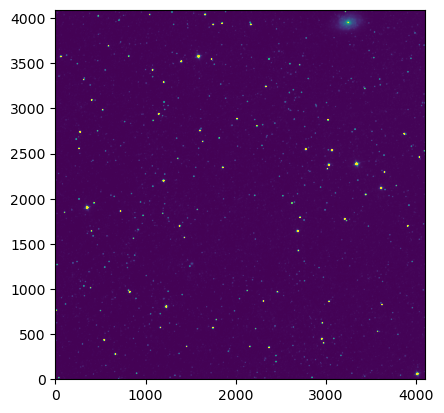

In [267]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

In [276]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
print(image1[0].header)
wcs


SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4095 / length of data axis 1                          NAXIS2  =                 4095 / length of data axis 2                          BUNIT   = 'DN      '           / image pixel units                              EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CRVAL1  =             0.000000 / RA at CRPIX1,CRPIX2, J2000.0 (deg)             CRVAL2  =           -33.317778 / Dec at CRPIX1,CRPIX2, J2000.0 (deg)            EQUINOX =               2000.0 / Equinox of WCS, (year)                         CTYPE1  = 'RA---SIN'           / Project

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  -33.317778  
CRPIX : 2048.0  2048.0  
NAXIS : 4095  4095

In [277]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs

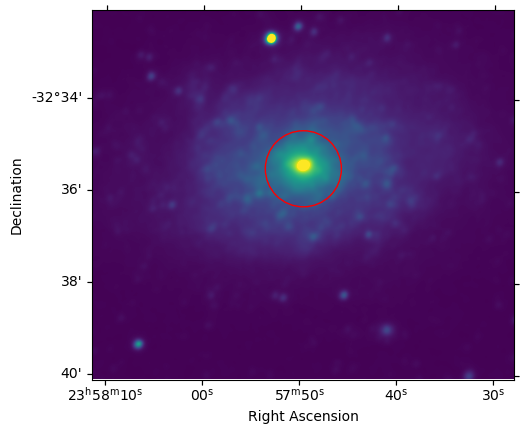

In [278]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 50)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

In [ ]:
#with fits.open('../Data/image_2MASS-K_s.fits') as image:
 #   image[0].data      # if you dont want to have to close the image again
    

hdul= fits.open('../Data/image_2MASS-K_s.fits')
hdul.info()

In [ ]:
fits1 = fits.getheader('../Data/image_2MASS-K_s.fits')


In [ ]:
data = hdul[1]

In [ ]:
#converting image data from counts to flux 
# encountered problem because this fits file does not have any other hdu's besides primaryHDU
photflam = hdul[1].header['photflam']
exptime = hdr['exptime']
data = data * photflam / exptime
hdul.close()

In [ ]:
#make sure to run this cell whenever done
hdul.close()

# Exploring the downloadable FITS provided by the website 
to understand the properties of the image

In [216]:
# looking at the WISE specific fits
hdul = fits.open('../Data/image_WISE-Band-1.fits')
hdul.info()

Filename: ../Data/image_WISE-Band-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (437, 369)   float32   


In [217]:
hdr = fits.getheader('../Data/image_WISE-Band-1.fits')
hdr
#the units are in units of intensity "DN"

SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  369 / length of data axis 2                          
BUNIT   = 'DN      '           / image pixel units                              
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =             0.000000 / RA at CRPIX1,CRPIX2, J2000.0 (deg)             
CRVAL2  =           -33.317778 / Dec at CRPIX1,CRPIX2, J2000.0 (deg)            
EQUINOX =               2000.0 / Equinox of WCS, (year)                         
CTYPE1  = 'RA---SIN'        

In [ ]:
#opening the image in a way similar to astroimagej
# for single aperture
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50)] #and , (180,340,50)

#create aperture objects
aperture = [CircularAperture((x,y),r) for (x,y,r) in ROI]


#perform aperture photometry
photo_table = aperture_photometry(phdul, aperture)
print(photo_table)
#results
for i, aperture in  enumerate(aperture):
    flux = photo_table['aperture_sum_0'][i]
print(flux)
hdul.close()

In [ ]:
# for multiple apertures
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220,220,100), (186,341,11)] #and , (180,340,50)

#results
for i, (x,y,r) in  enumerate(ROI):
   #create aperture objects 
    aperture = CircularAperture((x,y),r)
   #perform aperture photometry
    photo_table = aperture_photometry(phdul, aperture)
    #print(photo_table)
    flux = photo_table['aperture_sum'][0]
    print(f"Region {i+1}: Center=({x}, {y}), Radius={r}")
    print(f"Flux: {flux}")

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()
    

In [ ]:
#code for creating a background ring. also need to retrieve the source-sky uncertainty? leave that for later for now

In [ ]:
#converting vega magnitudesto source flux density for sources with constant power-law spectra: Fv proportional to V^not
#apparent magnitude of vega is .03  and absolute mag is .6
#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Flux conversion

In [69]:
#Converting counts in DN to flux density units
#Instrumental Zero Point Magnitude for WISE Source Photometry in the W1 Band is 20.73
#print(phdul)

#Confused cuz I am not sure what the variable is to convert all of the counts to flux


#Calibrated Magnitude
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
counts = flux # or phdul['MEDINT']? which is the median intensity
Mcal = M0instr - 2.5*(np.log10(counts))
#print(Mcal)

#convert Magnitude to Flux
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
flx_jy = flx_conv_fact * 10**(Mcal/-2.5)
print(flx_jy)



#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


0.014568425603228293


# Multi-aperture photometry code
## USING NGC 7793

   Region    X    Y  Radius  Annulus Inner Radius  Annulus Outer Radius  \
0       1  220  220     100                   135                   200   
1       2  186  341      10                    17                    25   

   Net Flux (Jy)  
0       0.393483  
1       0.009810  


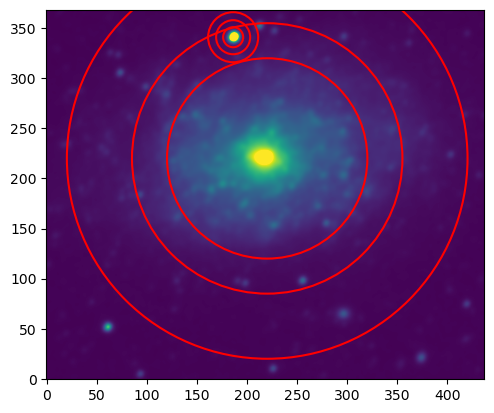

In [224]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()

    

# Creating background annuli

In [ ]:
#extract values of DN

#Sum background Annulus and inner aperture

#Convert DN to flux

#subtract background flux to get net flux

#display data in a pandas dataframe



# just in case
below I pasted in the earlier code in case something goes wrong

   Region    X    Y  Radius  Flux (Jy)
0       1  220  220     100   9.175685
1       2  186  341      11   0.110271


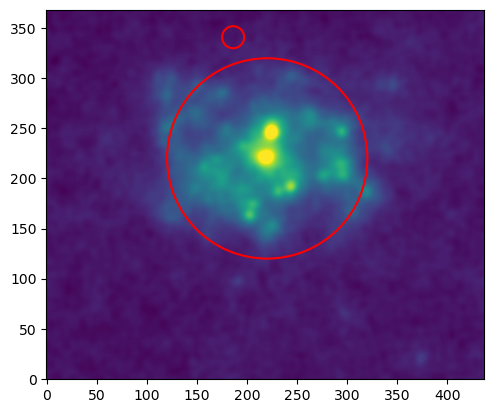

In [288]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100), (186, 341, 11)] # (x, y, r, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]

#results
for i, (x, y, r) in  enumerate(ROI):
# For the Target
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
   
    #converting counts to flux
    M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
    Mcal = M0instr - 2.5*(np.log10(target_counts))

    #convert Magnitude to Flux
    flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
    flx_jy = flx_conv_fact * 10**(Mcal/-2.5)

    
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Flux (Jy)': flx_jy})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()

# Doing multiple apertures on all Wavelengths and all the little dots
need to start on W4 and then work back in resolution and wavelength

doing this for NGC 7793

## For Band W4

,Region,X,Y,Radius,Annulus Inner Radius,Annulus Outer Radius,Net Flux (Jy)
0,1,225,245,12,40,60,0.124300
1,2,219,221,12,40,60,0.124479
2,3,320,185,12,40,60,0.122601
3,4,295,245,12,40,60,0.122902


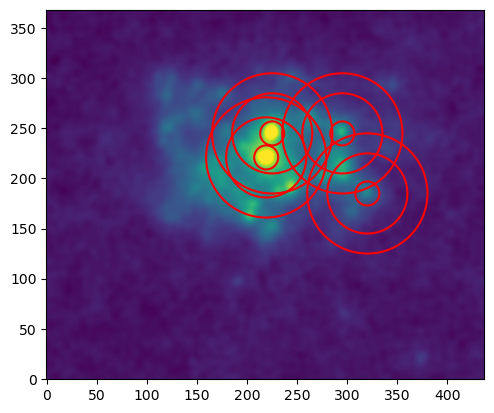

In [316]:
# starting on W4
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
phdul = hdul[0].data
plt.imshow(phdul, vmax = 152, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data


## For Band W3

,Region,X,Y,Radius,Annulus Inner Radius,Annulus Outer Radius,Net Flux (Jy)
0,1,225,245,12,40,60,0.438664
1,2,219,221,12,40,60,0.458583
2,3,320,185,12,40,60,0.412885
3,4,295,245,12,40,60,0.417817


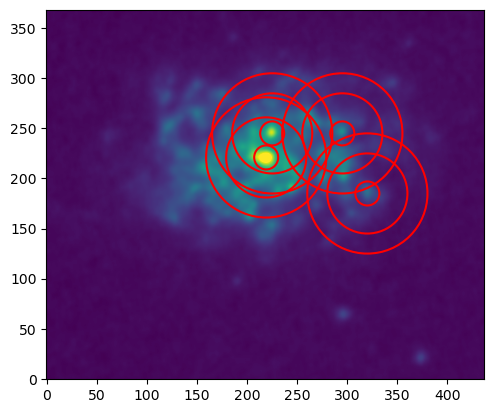

In [324]:

hdul = fits.open('../Data/imageNGC7793_WISE-Band-3.fits')# for band W3
phdul = hdul[0].data
plt.imshow(phdul, vmax = 575, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

## For Band W2

,Region,X,Y,Radius,Annulus Inner Radius,Annulus Outer Radius,Net Flux (Jy)
0,1,225,245,12,40,60,0.013165
1,2,219,221,12,40,60,0.020263
2,3,320,185,12,40,60,0.008359
3,4,295,245,12,40,60,0.009478


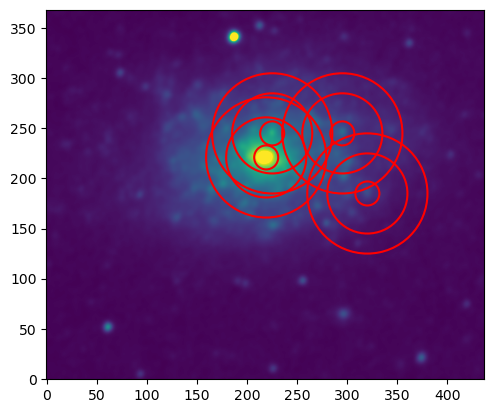

In [330]:
hdul = fits.open('../Data/image_WISE-Band-2.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 25, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

## For Band W1

,Region,X,Y,Radius,Annulus Inner Radius,Annulus Outer Radius,Net Flux (Jy)
0,1,225,245,12,40,60,0.017478
1,2,219,221,12,40,60,0.035215
2,3,320,185,12,40,60,0.006456
3,4,295,245,12,40,60,0.009062


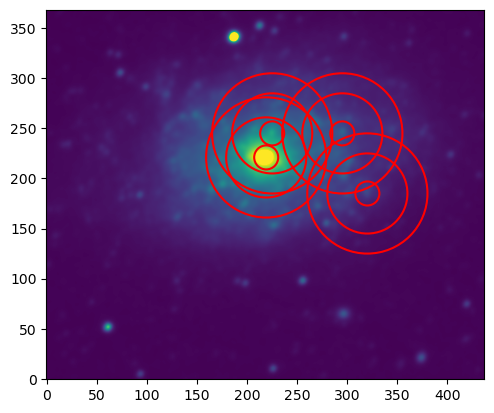

In [332]:
hdul = fits.open('../Data/image_WISE-Band-1.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

**Original code for everything aperture related**

,Region,X,Y,Radius,Annulus Inner Radius,Annulus Outer Radius,Net Flux (Jy)
0,1,220,220,100,135,200,0.393483
1,2,186,341,10,17,25,0.009810


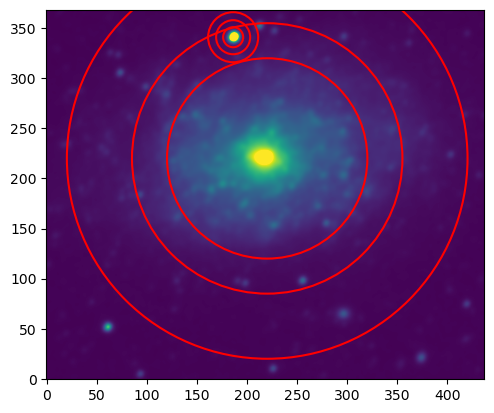

In [295]:
#For W1
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)


#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data
